In [19]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy import signal, interpolate

from datetime import time, timedelta
import matplotlib.dates as mdates
from datetime import datetime

from MAppServer.settings import DOWNLOAD_FOLDER_ABSOLUTE_PATH
from data_analysis import subjects_to_keep


In [20]:
users = subjects_to_keep.subjects_to_keep

# Try things out with one user

n days:  19


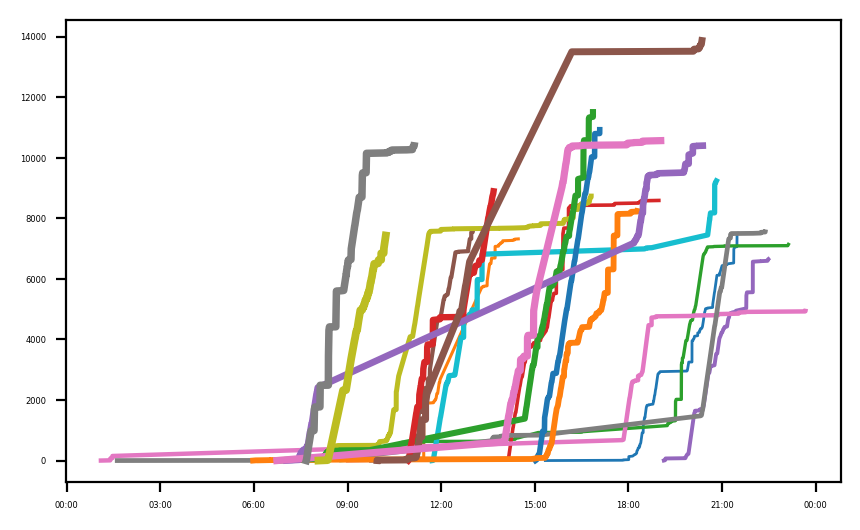

In [21]:
u =  users[0] #"11KD" #"09AU"  "11KD"
file = glob.glob(f"{DOWNLOAD_FOLDER_ABSOLUTE_PATH}/{u}_activity*.csv")[0]
#     print(f"Found the file `{file}`")

df = pd.read_csv(file, index_col=0)
df.dt = pd.to_datetime(df.dt, utc=False, format='ISO8601')
df.dt = df.dt.dt.tz_convert('Europe/London')

uniq_date = df.dt.dt.date.unique()

print("n days: ", len(uniq_date))

fig, ax = plt.subplots(figsize=(5, 3))
for date in uniq_date:
    df_date = df[df.dt.dt.date == date]
    min_date = df.dt.dt.date.min()
    n_days_since_beginning = (date - min_date).days
    x = df_date.dt.map(lambda entry: entry.replace(day=1, month=1, year=2000))

    y = df_date.step_midnight.values

    # Patch in case of re-installation
    if np.sum(np.diff(y) < 0) > 0:
        idx = 1 + np.arange(len(y)-1)[np.diff(y) < 0][0]
        y[idx:] =  y[idx-1] + y[idx:] - y[idx]

    # Plot
    ax.plot(x, y, linewidth=1 + n_days_since_beginning*0.1)
    xformatter = mdates.DateFormatter('%H:%M', )
    ax.xaxis.set_major_formatter(xformatter)

plt.show()

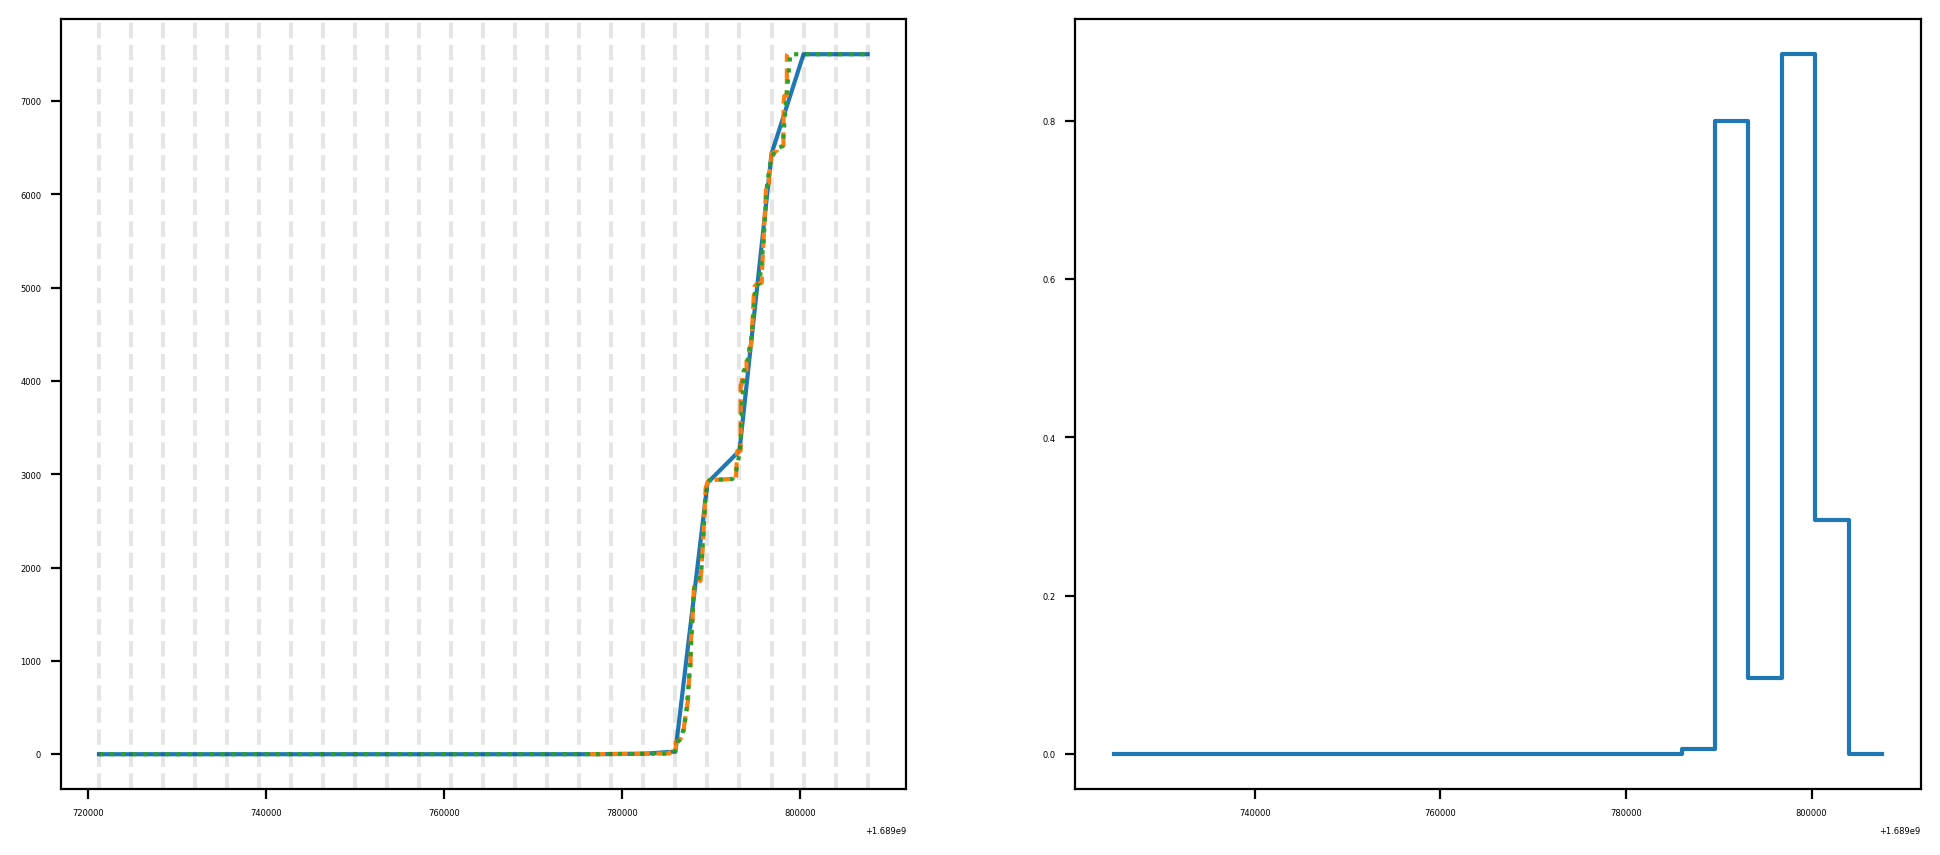

In [26]:
df_date = df[df.dt.dt.date == uniq_date[0]]

dx = 60*60

# Reference point (today but the choice is arbitrary)
some_day = datetime.today()
midnight = datetime.combine(some_day, time.min)
min_ts = midnight.timestamp()
max_ts = (midnight + timedelta(days=1)).timestamp()

x = df_date.dt.map(lambda entry: entry.replace(day=some_day.day, month=some_day.month, year=some_day.year))
x_sec = x.map(lambda entry: entry.timestamp()).values
y = df_date.step_midnight.values

# Do the interpolation
f = interpolate.interp1d(x_sec, y, kind="linear")
# min_val = 0
# max_val = max_ts - min_ts
x_new = np.arange(min_ts, max_ts+0.00001, dx)
y_new = np.zeros_like(x_new)
# idx = np.arange(len(x_new))
can_be_interpolated = (x_new >= x_sec.min()) * (x_new <= x_sec.max())
y_new[can_be_interpolated] = f(x_new[can_be_interpolated])
y_new[x_new < x_sec.min()] = 0
y_new[x_new > x_sec.max()] = y.max()

x_lin = np.linspace(min_ts, max_ts, 200)
y_lin = np.zeros_like(x_lin)
can_be_interpolated = (x_lin >= x_sec.min()) * (x_lin <= x_sec.max())
y_lin[can_be_interpolated] = f(x_lin[can_be_interpolated])
y_lin[x_lin < x_sec.min()] = 0
y_lin[x_lin > x_sec.max()] = y.max()

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
ax = axes[0]
ax.plot(x_new, y_new)
ax.plot(x_sec, y, linestyle="--")

ax.plot(x_lin, y_lin, linestyle=":")
for x in x_new:
    ax.axvline(x, linestyle="--", color="black", alpha=0.1)

ax = axes[1]
ax.step(x_new[1:], np.diff(y_new)/dx, where="post");

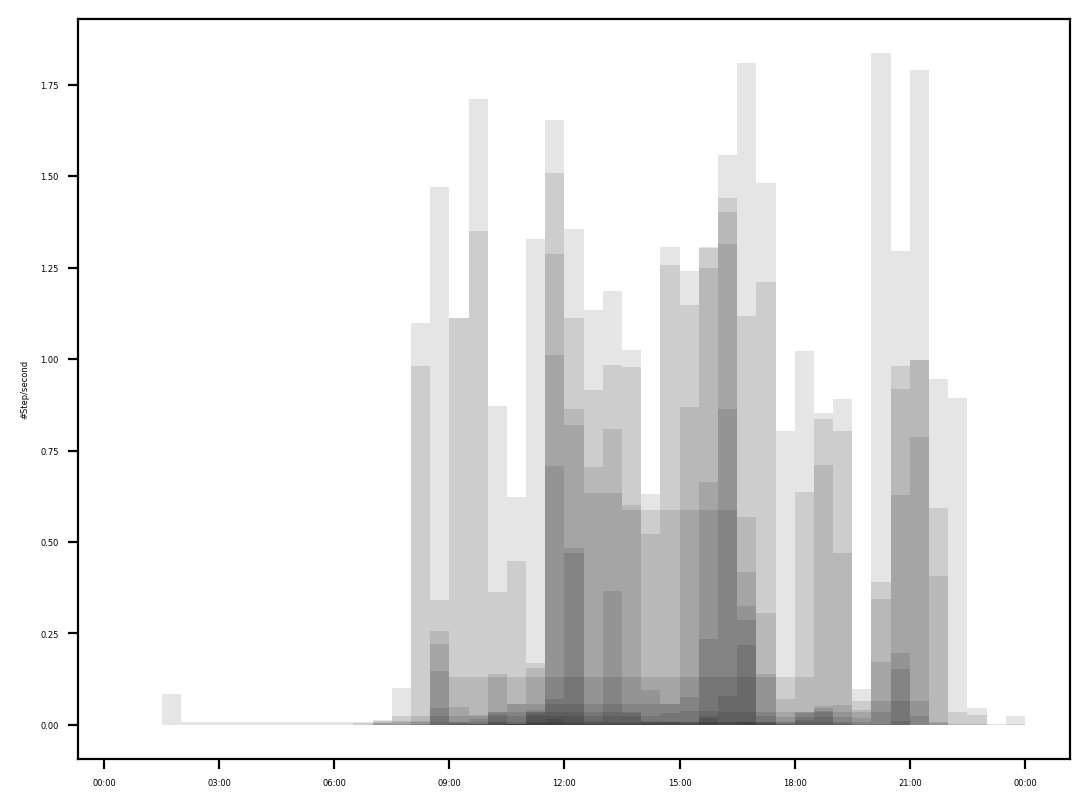

In [27]:
fig, ax = plt.subplots()
for date in uniq_date:

    # Select data from that date
    df_date = df[df.dt.dt.date == date]

    # Reference point (today but the choice is arbitrary)
    some_day = datetime.today()
    midnight = datetime.combine(some_day, time.min)
    min_ts = midnight.timestamp()
    max_ts = (midnight + timedelta(days=1)).timestamp()

    x = df_date.dt.map(lambda entry: entry.replace(day=some_day.day, month=some_day.month, year=some_day.year))
    x_sec = x.map(lambda entry: entry.timestamp()).values # - min_ts
    y = df_date.step_midnight.values

    # Patch in case of re-installation
    if np.sum(np.diff(y) < 0) > 0:
        idx = 1 + np.arange(len(y)-1)[np.diff(y) < 0][0]
        y[idx:] =  y[idx-1] + y[idx:] - y[idx]

    # Choose some time precision
    dx = 60*30

    # Do the interpolation
    f = interpolate.interp1d(x_sec, y, kind="linear")
    # min_val = 0
    # max_val = max_ts - min_ts
    x_new = np.arange(min_ts, max_ts+0.00001, dx)
    y_new = np.zeros_like(x_new)
    # idx = np.arange(len(x_new))
    can_be_interpolated = (x_new >= x_sec.min()) * (x_new <= x_sec.max())
    y_new[can_be_interpolated] = f(x_new[can_be_interpolated])
    y_new[x_new < x_sec.min()] = 0
    y_new[x_new > x_sec.max()] = y.max()

    # Compute the diff
    y_diff = np.diff(y_new)/dx
    x_diff =  [datetime.fromtimestamp(x_) for x_ in x_new[1:]]

    # Plot
    color = "black"
    ax.fill_between(x_diff, y_diff, step="post", alpha=0.1, color=color, linewidth=0)
    #ax.step(x_diff, y_diff, where="post", color=color, linewidth=0.2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', ))
ax.set_ylabel("#Step/second")
plt.show()

# Look at all users

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/02MY_activity_2023-07-19_19-34-10.csv`...
n rows = 106958


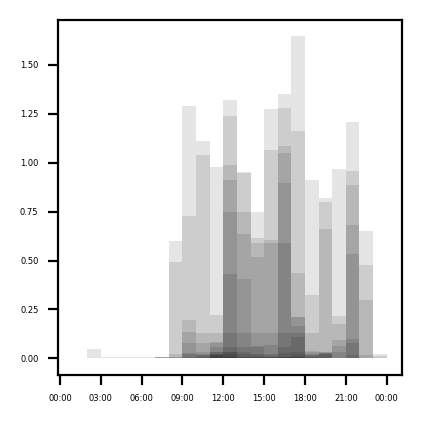

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/102P_activity_2023-07-19_19-34-10.csv`...
n rows = 45930


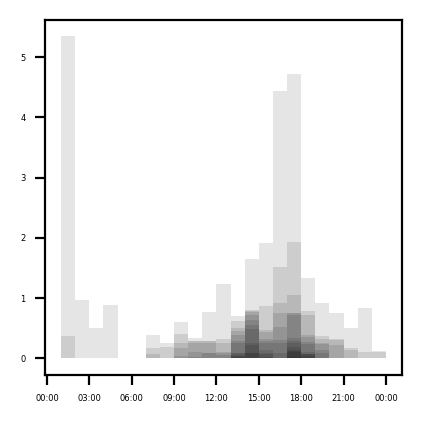

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/10AN_activity_2023-07-19_19-34-10.csv`...
n rows = 199276


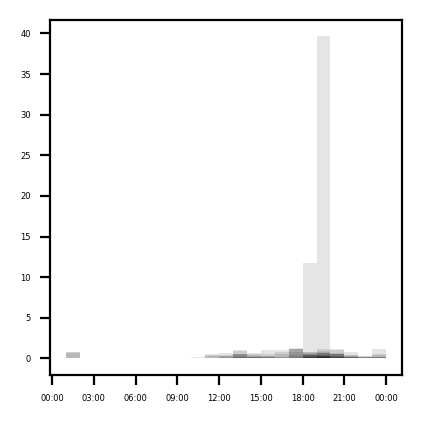

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/11AV_activity_2023-07-19_19-34-10.csv`...
n rows = 66486


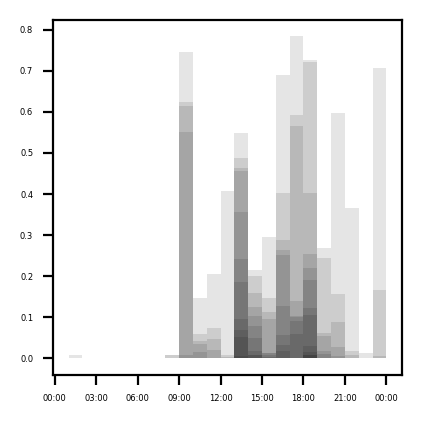

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/11KD_activity_2023-07-19_19-34-10.csv`...
n rows = 106231


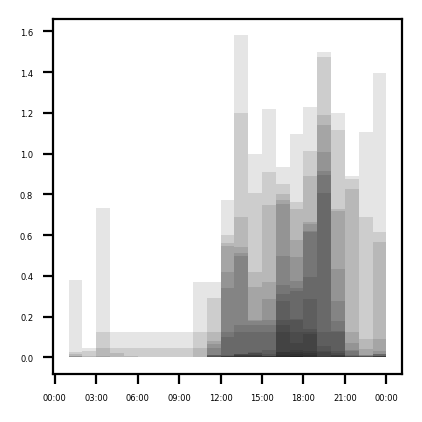

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/12JA_activity_2023-07-19_19-34-10.csv`...
n rows = 64253


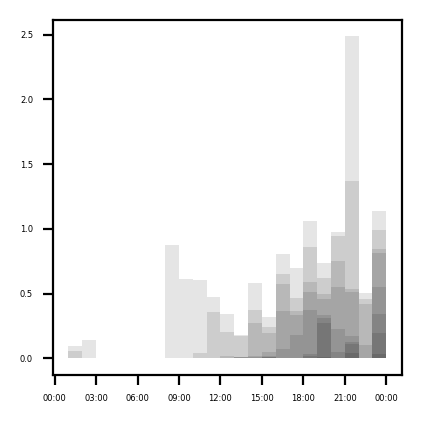

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/18DA_activity_2023-07-19_19-34-10.csv`...
n rows = 153291


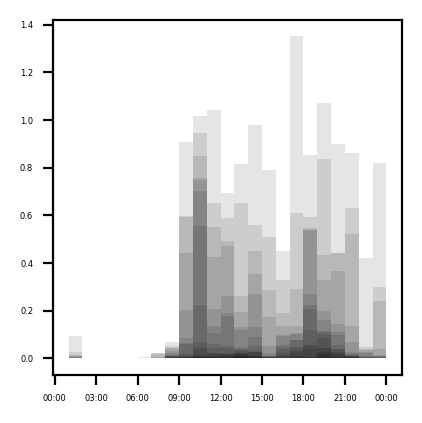

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/19AN_activity_2023-07-19_19-34-10.csv`...
n rows = 60882


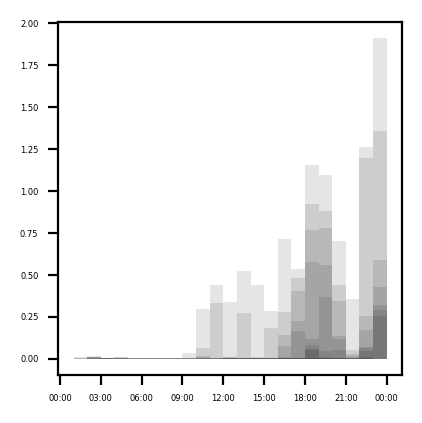

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/19EN_activity_2023-07-19_19-34-10.csv`...
n rows = 103161


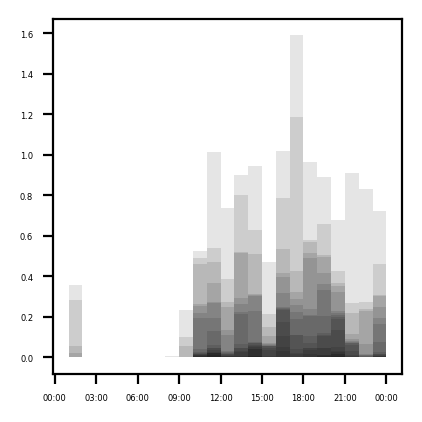

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/272W_activity_2023-07-19_19-34-10.csv`...
n rows = 12984


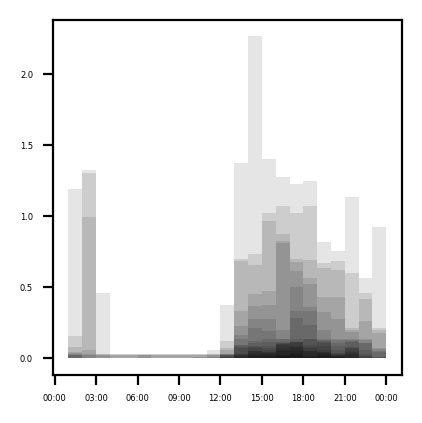

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/302M_activity_2023-07-19_19-34-10.csv`...
n rows = 234785


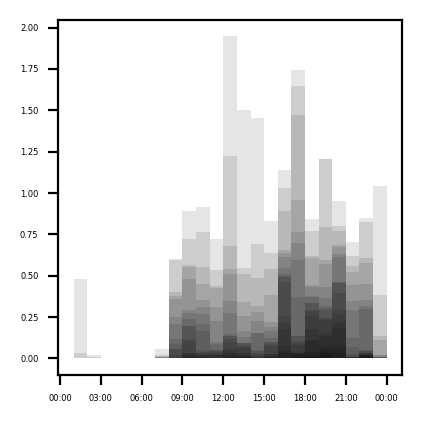

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/13KU_activity_2023-07-19_19-34-10.csv`...
n rows = 67772


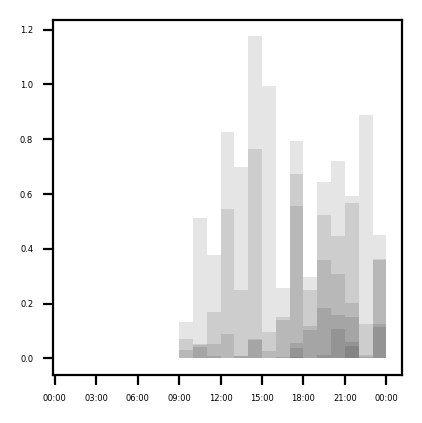

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/152G_activity_2023-07-19_19-34-10.csv`...
n rows = 162851


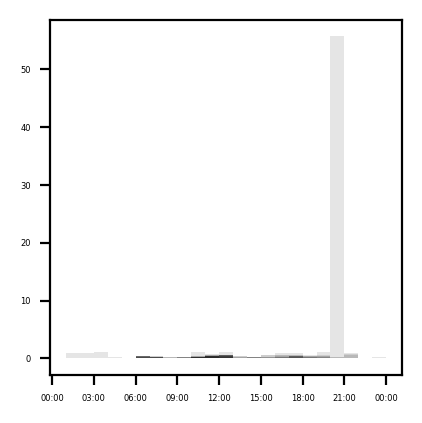

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/152O_activity_2023-07-19_19-34-10.csv`...
n rows = 48547


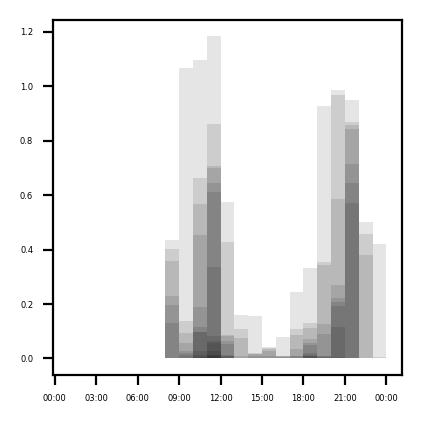

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/15SM_activity_2023-07-19_19-34-10.csv`...
n rows = 65499


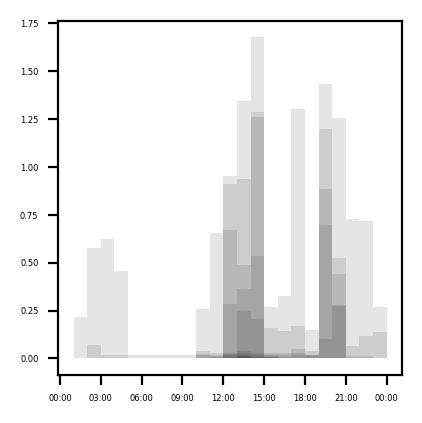

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/22MH_activity_2023-07-19_19-34-10.csv`...
n rows = 112817


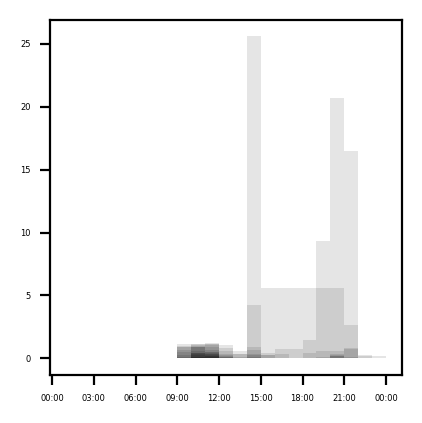

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/23MI_activity_2023-07-19_19-34-10.csv`...
n rows = 1
Skipping /Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/23MI_activity_2023-07-19_19-34-10.csv, not enough entries
Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/27SI_activity_2023-07-19_19-34-10.csv`...
n rows = 34265


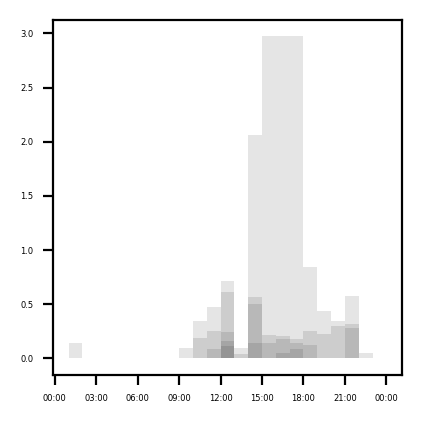

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/28OM_activity_2023-07-19_19-34-10.csv`...
n rows = 150228


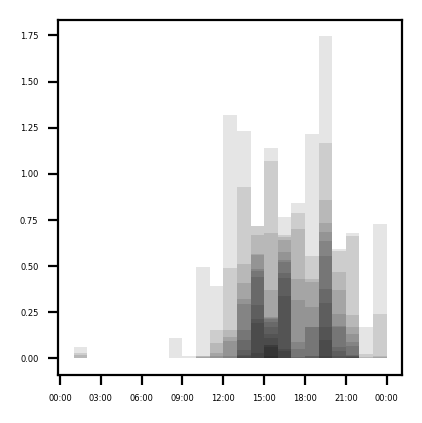

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/02TA_activity_2023-07-19_19-34-10.csv`...
n rows = 24634


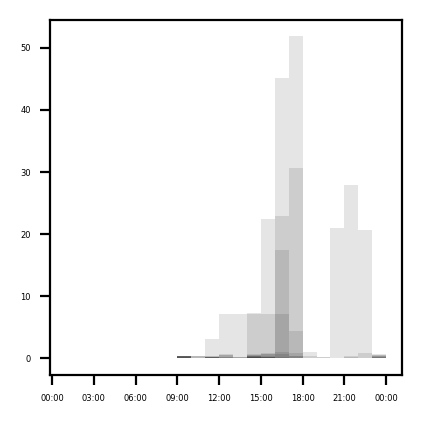

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/09AU_activity_2023-07-19_19-34-10.csv`...
n rows = 14401


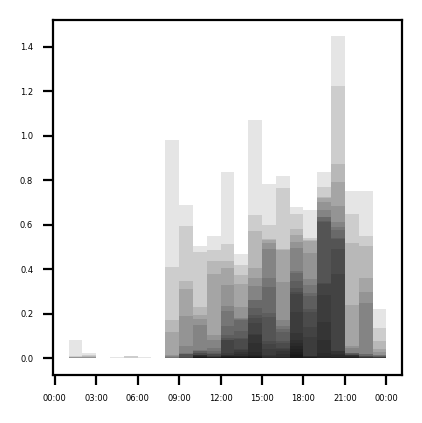

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/11SA_activity_2023-07-19_19-34-10.csv`...
n rows = 38499


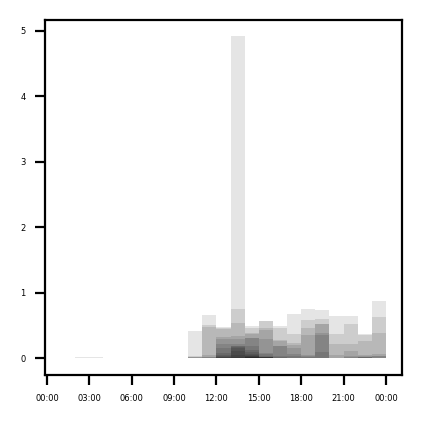

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/132L_activity_2023-07-19_19-34-10.csv`...
n rows = 23041


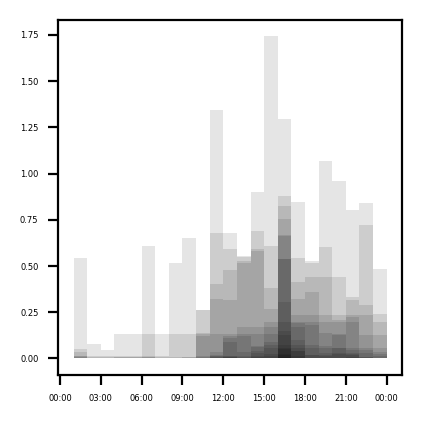

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/152A_activity_2023-07-19_19-34-10.csv`...
n rows = 74515


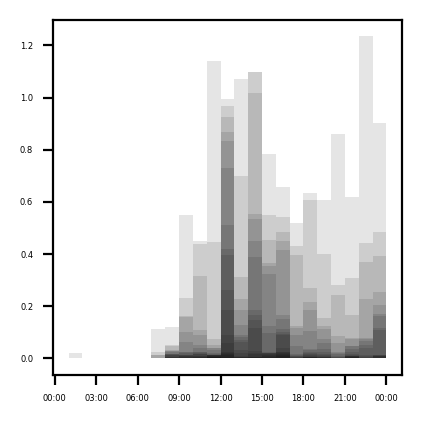

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/162W_activity_2023-07-19_19-34-10.csv`...
n rows = 112272


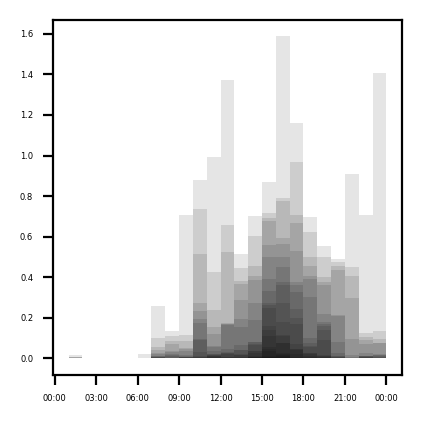

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/192Z_activity_2023-07-19_19-34-10.csv`...
n rows = 30096


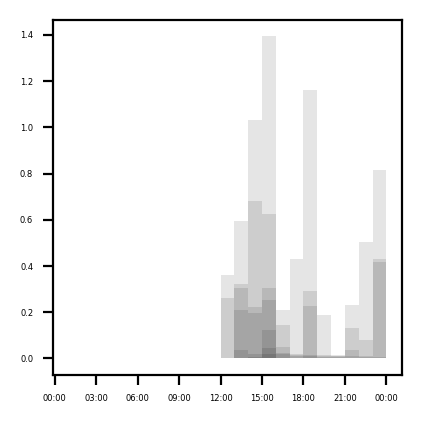

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/272L_activity_2023-07-19_19-34-10.csv`...
n rows = 66962


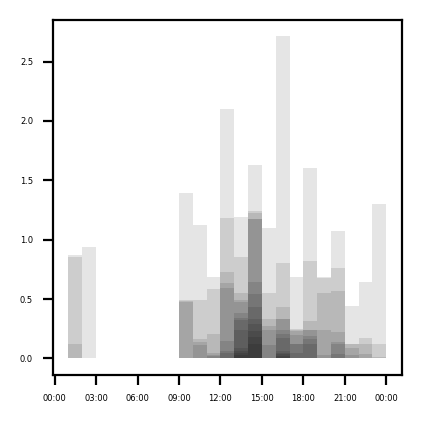

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/15MM_activity_2023-07-19_19-34-10.csv`...
n rows = 78754


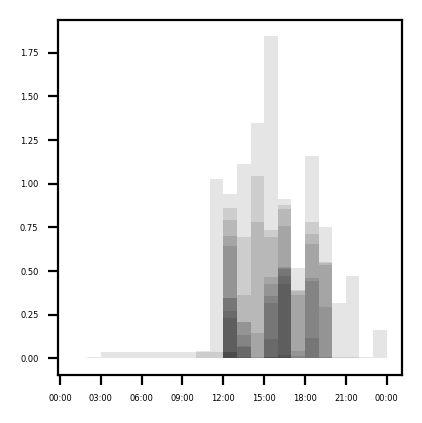

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/09A1_activity_2023-07-19_19-34-10.csv`...
n rows = 70776


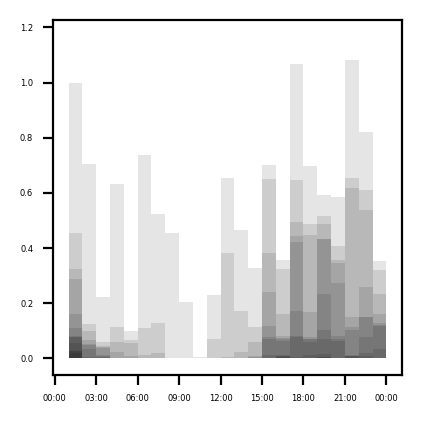

Considering the file `/Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/06AS_activity_2023-07-19_19-34-10.csv`...
n rows = 3797
Skipping /Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/06AS_activity_2023-07-19_19-34-10.csv, not enough entries


In [31]:
# Choose some time precision
dx = 60*60

for u in users:

    # if "smallobj" in file or "michele" in file or "student" in file:
    #     print(f"Skipping file `{file}`")
    #     continue

    file = glob.glob(f"{DOWNLOAD_FOLDER_ABSOLUTE_PATH}/{u}_activity*.csv")[0]

    print(f"Considering the file `{file}`...")

    df = pd.read_csv(file, index_col=0)
    print(f"n rows = {len(df)}")
    if len(df) < 5000:
        print(f"Skipping {file}, not enough entries")
        continue

    df.dt = pd.to_datetime(df.dt, utc=False, format='ISO8601')
    df.dt = df.dt.dt.tz_convert('Europe/London')

    uniq_date = df.dt.dt.date.unique()

    plt.rcParams.update({'font.size': 3})
    fig, ax = plt.subplots(figsize=(2, 2))
    for date in uniq_date:

        # Select data from that date
        df_date = df[df.dt.dt.date == date]

        # Reference point (today but the choice is arbitrary)
        some_day = datetime.today()
        midnight = datetime.combine(some_day, time.min)
        min_ts = midnight.timestamp()
        max_ts = (midnight + timedelta(days=1)).timestamp()

        x = df_date.dt.map(lambda entry: entry.replace(day=some_day.day, month=some_day.month, year=some_day.year))
        x_sec = x.map(lambda entry: entry.timestamp()).values - min_ts
        y = df_date.step_midnight.values

        # Patch in case of re-installation
        if np.sum(np.diff(y) < 0) > 0:
            idx = 1 + np.arange(len(y)-1)[np.diff(y) < 0][0]
            y[idx:] =  y[idx-1] + y[idx:] - y[idx]

        # Do the interpolation
        f = interpolate.interp1d(x_sec, y, kind="linear")
        min_val = 0
        max_val = max_ts - min_ts
        x_new = np.arange(min_val, max_val+0.00001, dx)
        y_new = np.zeros_like(x_new)
        idx = np.arange(len(x_new))
        can_be_interpolated = idx[(x_new >= x_sec.min()) * (x_new <= x_sec.max())]
        y_new[can_be_interpolated] = f(x_new[can_be_interpolated])
        y_new[x_new < x_sec.min()] = 0
        y_new[x_new > x_sec.max()] = y.max()

        # Compute the diff
        y_diff = np.diff(y_new) /dx
        x_diff =  [datetime.fromtimestamp(min_ts + x_) for x_ in x_new[1:]]

        # Plot
        color = "black"
        ax.fill_between(x_diff, y_diff, step="post", alpha=0.1, color=color, linewidth=0)
        #ax.step(x_diff, y_diff, where="post", color=color, linewidth=0.2)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', ))
    fig.tight_layout()
    plt.show()